# Import

In [1]:
import os
import pathlib
import sys
from pathlib import __file__

import numpy as np
import tensorflow as tf

sys.path.insert(0, pathlib.Path().absolute().parent.parent.parent.__str__())
sys.path.append(os.path.join(os.path.dirname(__file__), "../../../../src"))

sys.dont_write_bytecode = True

from LSB_recognizer_model.src.coordenates.data.split_dataset import SplitDataset
from utils.holistic.holistic_detector import HolisticDetector
from LSB_recognizer_model.src.utils.sign_dataset import SignDataset

In [2]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("CPU Available: ", tf.config.list_physical_devices('CPU'))

GPU Available:  []
CPU Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
# ----------------- PATHS --------------------------

PATH_PREDICTED_IMG = "../../data/processed/Draw"

PATH_RAW_SIGNS = "../../data/raw/Signs"
PATH_NUMPY_COORDS = "../../data/processed/NumpyParallel"

PATH_CHECKPOINTS_LOAD = "../../models/9-checkpoints-coord-93,3%-zurdo-normalizado"
PATH_CHECKPOINTS_SAVE = "../../models/checkpoints-coord-prueba"

# 1. Definición data aug para imagenes antes de predicción

## 1.1. Transformaciones Individuales
Se debe crear una lista de tuplas donde el primer valor es la cantidad de imagenes a generar con esta transformación y el segundo valor es la transformación a aplicar.
Esta transformación duplica el dataset y aplica la transformación a cada imagen, para posteriormente concatenar el dataset original con el dataset transformado. Todo este proceso se hace por cada transformación de la lista.

Ej: Si se tiene un dataset de 10 imagenes y se hace (1, voltear_imagen) se obtendrán 20 imagenes; 10 con las imagenes originales y 10 con las imagenes volteadas. Y se aplica antes de las otras transformaciones.)

In [4]:
import cv2

def single_aug(image):
    image = cv2.flip(image, 1)
    return image
    
image_single_aug = (1, single_aug)

## 1.2. Transformaciones Separadas
Se debe crear una lista de tuplas donde el primer valor es la cantidad de imagenes a generar con esta transformación y el segundo valor es la transformación a aplicar.

Esta transformación duplica el dataset y aplica la transformación a cada imagen, para posteriormente concatenar el dataset original con el dataset transformado. 
A diferencia de las transformaciones individuales, esta transformación no coge las otras transformaciones que estan en la lista.

In [5]:
import random

def rotation(image, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    image = cv2.warpAffine(image, M, (w, h))
    return image

def zoom(img, value):
    def fill(img, h, w):
        img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
        return img

    if value > 1 or value < 0:
        print('Value for zoom should be less than 1 and greater than 0')
        return img

    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img, h, w)
    return img

image_separated_aug = [
    (3, lambda image: rotation(image, 10)),
    (3, lambda image: zoom(image, 0.5)),
]

# 2. Capa Split Dataset (Train, Validation y Test)

## 2.1. Obtener datasets desde los archivos de las imagenes

Se encarga de generar el dataset con los archos de imagenes directamente.

Si se le pone la variable `save_path_numpy` los results se guardan en la carpeta indicada en formato .npy (coordenadas), es recomendable usar esta variable para que solo se ejecute una vez el proceso de data aug.

Si se le pone la variable `save_path_image_detection_draw` se guardan los results en la carpeta indicada en formato .jpg pintando los landmarks en las imagenes.

Por último están las variables `cant_rotations_per_axie_data_aug`, `x_max_rotation`, `y_max_rotation`, `z_max_rotation` se definen de mejor manera dentro del archivo `src/utils/landmarks/landmarks_info.py` función `data_aug_coords` 

In [6]:
# Comentar esta celda una vez se haya ejecutado por primera vez

split_dataset = SplitDataset(path_raw_image=PATH_RAW_SIGNS)
train, test, validation, _ = split_dataset.get_splited_files(
   save_path_numpy=PATH_NUMPY_COORDS,
    save_path_image_detection_draw = PATH_PREDICTED_IMG,
   image_single_aug=image_single_aug,
   image_separated_aug=image_separated_aug,
   cant_rotations_per_axie_data_aug = [2,2,2],
   x_max_rotation=25,
   y_max_rotation=40,
   z_max_rotation=20,
)

En la imagen ../../data/raw/Signs/pelea/0_notprocessed.jpg no se pudo detectar ambas manos
En la imagen ../../data/raw/Signs/pelea/0_notprocessed.jpg no se pudo detectar ambas manos
En la imagen ../../data/raw/Signs/pelea/0_notprocessed.jpg no se pudo detectar ambas manos
En la imagen ../../data/raw/Signs/pelea/0_notprocessed.jpg no se pudo detectar ambas manos
En la imagen ../../data/raw/Signs/pelea/10_notprocessed.jpg no se pudo detectar ambas manos
En la imagen ../../data/raw/Signs/pelea/10_notprocessed.jpg no se pudo detectar ambas manos
En la imagen ../../data/raw/Signs/pelea/10_notprocessed.jpg no se pudo detectar ambas manos
En la imagen ../../data/raw/Signs/pelea/10_notprocessed.jpg no se pudo detectar ambas manos
En la imagen ../../data/raw/Signs/pelea/10_notprocessed.jpg no se pudo detectar ambas manos
En la imagen ../../data/raw/Signs/pelea/11_notprocessed.jpg no se pudo detectar ambas manos
En la imagen ../../data/raw/Signs/pelea/11_notprocessed.jpg no se pudo detectar amba

KeyboardInterrupt: 

## 2.2 Obtener datasets desde los archivos de las coordenadas (.npy)

In [9]:
split_dataset = SplitDataset(path_numpy=PATH_NUMPY_COORDS)
train, test, validation, _ = split_dataset.get_splited_files()

KeyboardInterrupt: 

# 3. Arreglo datos
Este proceso es para ajustar correctamente los datos para usar solo las coordenadas de los landmarks que se van a usar.

In [16]:
X_train, Y_train = split_dataset.get_only_specific_parts_and_fix(
    train, used_parts=["pose", "left_hand", "right_hand"]
)
X_test, Y_test = split_dataset.get_only_specific_parts_and_fix(
    test, used_parts=["pose", "left_hand", "right_hand"]
)
X_validation, Y_validation = split_dataset.get_only_specific_parts_and_fix(
    validation, used_parts=["pose", "left_hand", "right_hand"]
)


In [17]:
len(train)

7307

In [18]:
len(train[0][0][3])

1404

In [19]:
len(X_train), len(Y_train)

(7307, 7307)

# 4. Capa Modelo

In [20]:
classes = split_dataset.get_classes()
steps_per_epoch = split_dataset.get_recomend_steps_per_epoch()

## 4.1 Creación de capa modelo
Se ingresa el modelo creado y los datos de entrenamiento y validación.

In [21]:
from LSB_recognizer_model.src.utils.sign_model import SignModel
from LSB_recognizer_model.src.coordenates.models.coordenates_models import INPUT_SHAPE_FIX, get_model_coord_dense_3

modelo = SignModel(
    model = get_model_coord_dense_3(INPUT_SHAPE_FIX, len(classes)),
    dataset_train = None,
    dataset_validation = None,
    X_train = X_train,
    Y_train = Y_train,
    X_validation = X_validation,
    Y_validation = Y_validation
)

2023-10-12 03:47:31.426676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 4.2 Definir callbacks

In [22]:
from keras.callbacks import ModelCheckpoint, TensorBoard

# ============ TensorBoard ============
# To open tensorboard: tensorboard --logdir=. on the folder where the logs are.
log_dir = f"{PATH_CHECKPOINTS_SAVE}/logs"
tb_callback = TensorBoard(log_dir=log_dir)

# ============ Checkpoints ============
checkpoint_filepath = PATH_CHECKPOINTS_SAVE
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor = 'val_accuracy', verbose=1, save_best_only=True, mode='max')

# ========== Callbacks list ============
callbacks_list = [checkpoint, tb_callback]

# 4.3 Entrenar modelo

In [23]:
modelo.train_model(
    epochs = 500,
    optimizer = "Adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"],
    callbacks = callbacks_list,
    steps_per_epoch = steps_per_epoch,
    verbose=1,
)
#496 m 47 s

Epoch 1/500
228/229 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.9859
Epoch 1: val_accuracy improved from -inf to 0.98472, saving model to ../../models/checkpoints-coord-prueba
INFO:tensorflow:Assets written to: ../../models/checkpoints-coord-prueba/assets
229/229 [==============================] - 7s 21ms/step - loss: 0.3486 - accuracy: 0.9858 - val_loss: 0.1124 - val_accuracy: 0.9847
Epoch 2/500
224/229 [============================>.] - ETA: 0s - loss: 0.0741 - accuracy: 0.9870
Epoch 2: val_accuracy improved from 0.98472 to 0.99127, saving model to ../../models/checkpoints-coord-prueba
INFO:tensorflow:Assets written to: ../../models/checkpoints-coord-prueba/assets
229/229 [==============================] - 3s 14ms/step - loss: 0.0734 - accuracy: 0.9870 - val_loss: 0.0443 - val_accuracy: 0.9913
Epoch 3/500
227/229 [============================>.] - ETA: 0s - loss: 0.0372 - accuracy: 0.9924
Epoch 3: val_accuracy did not improve from 0.99127
229/229 [========

## 4.4 Guardar results del entrenamiento

29/29 [==============================] - 0s 6ms/step


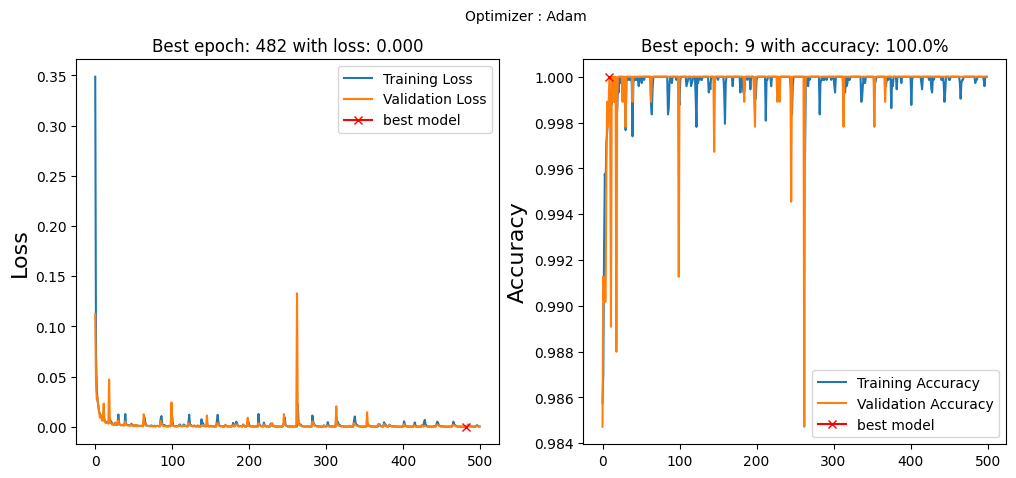

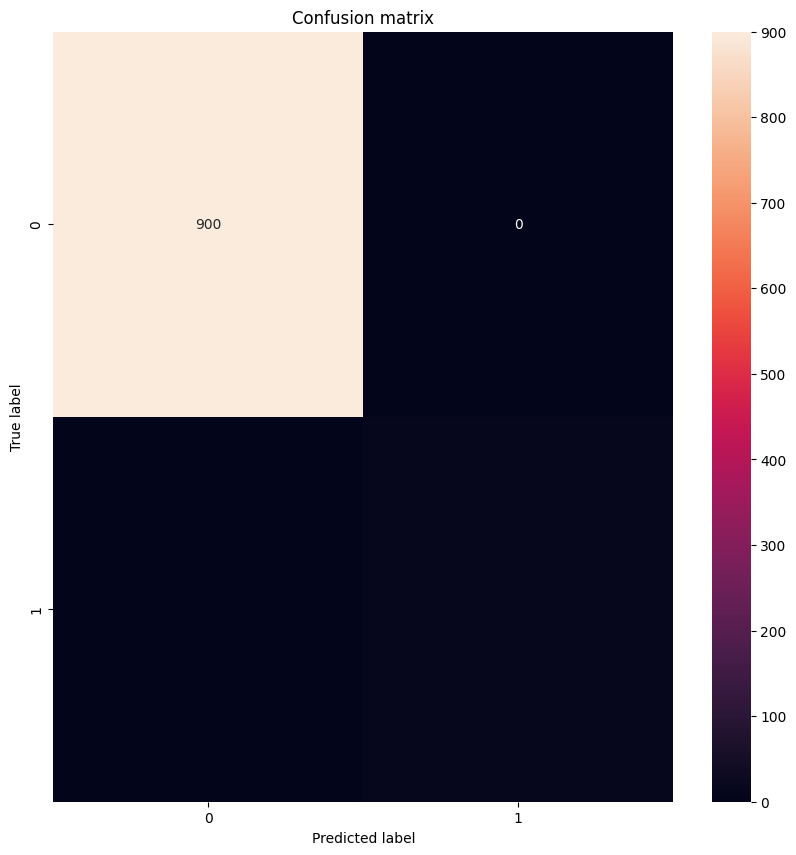

In [24]:
plot_acc_los, plot_confusion_matrix = modelo.save_plot_results(
    X_test = X_test,
    Y_test = Y_test,
    path_to_save = PATH_CHECKPOINTS_SAVE
)

## 4.4 Visualizar results del entrenamiento

[]

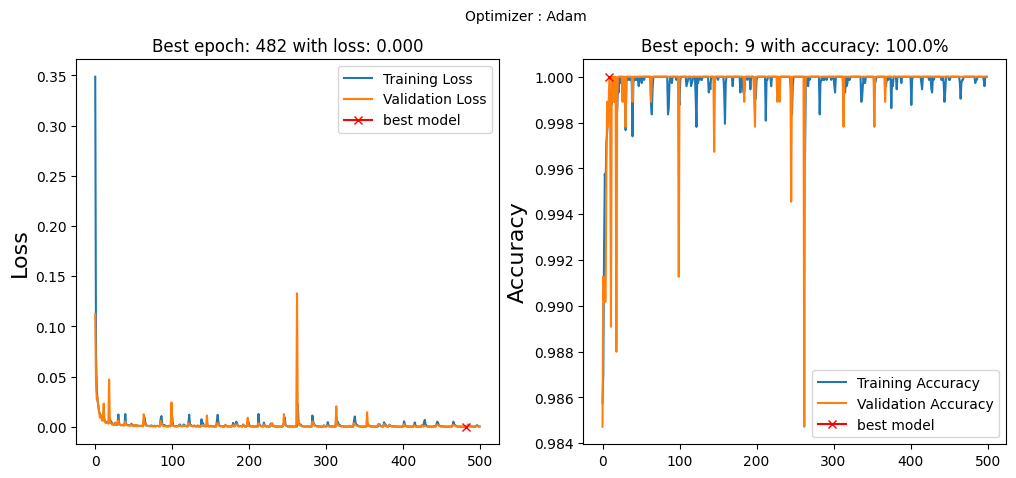

In [25]:
#plot_acc_los = modelo.get_plot_acc_loss()
#plot_acc_los.plot()

29/29 [==============================] - 0s 4ms/step


[]

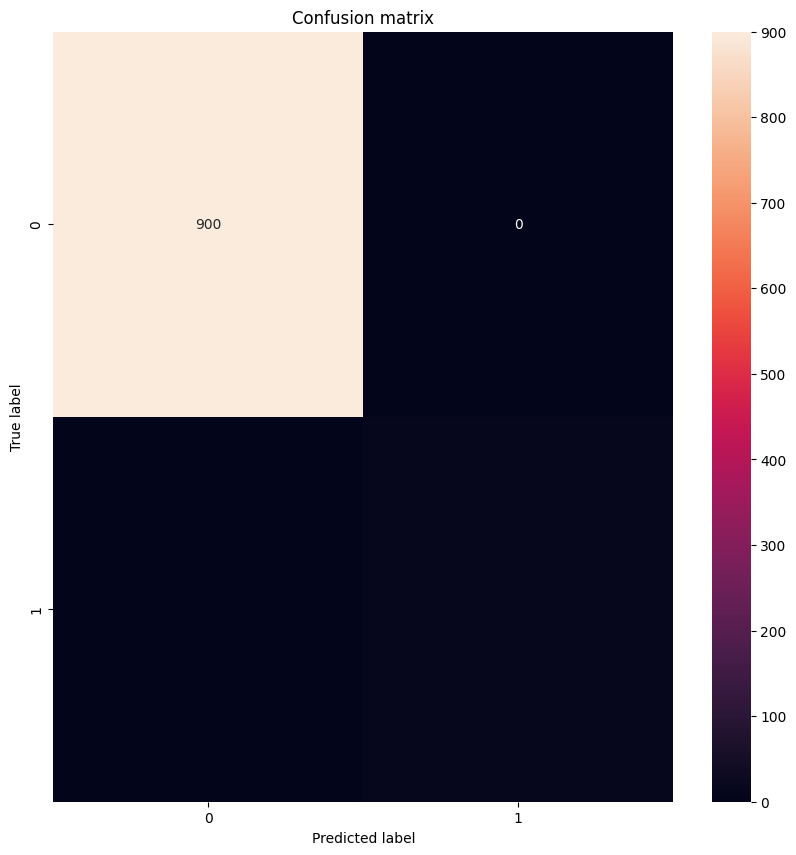

In [26]:
#plot_confusion_matrix, score = modelo.get_plot_confusion_matrix(X_test, Y_test)
#plot_confusion_matrix.plot()

# 5. Cargar Pesos de modelo
Esto se puede usar cuando se quiere cargar los pesos de un modelo ya entrenado sin tener que volver a entrenar el modelo.

In [29]:
# Path al modelo recien entrenado
modelo.load_model_weights(PATH_CHECKPOINTS_SAVE)

# Path al modelo a cargar (por lo general el mejor)
#modelo.load_model_weights(PATH_CHECKPOINTS_LOAD)

2023-10-12 04:07:17.480783: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ../../models/checkpoints-coord-prueba: FAILED_PRECONDITION: ../../models/checkpoints-coord-prueba; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


# 5. Prueba reales de los resultados

In [2]:
import time

import cv2
from utils.holistic.holistic_detector import HolisticDetector

ptiempo = 0

# Crearemos el objeto
holistic = HolisticDetector()

# Leemos la cámara web
cap = cv2.VideoCapture(0)

while cap.isOpened():
    
    # Leemos el fotograma de la cámara
    success, image = cap.read()

    if not success:
        break

    # Una vez que obtengamos la imagen la enviaremos
    results = holistic.detect_holistic(image)
    
    # Dibujamos la predicción en el fotograma
    image = holistic.draw_prediction(image, results)

    # Predicción
    x = holistic.get_coordenates(results, used_parts=["pose", "right_hand", "left_hand"])
    try:
        res = modelo.get_prediction(x, classes)
    except Exception as e:
        print("Error: ", e)

    # Viz probabilities
    image = holistic.probability_visualizer(res, classes, image)

    # Mostramos los fps
    ctiempo = time.time()
    fps = 1 / (ctiempo - ptiempo)
    ptiempo = ctiempo
    cv2.putText(image, str(int(fps)), (image.shape[1]-100, 70), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 255), 3)

    # Mostramos todo el fotograma modificado
    cv2.imshow("holistic", image)

    # Break gracefully
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

    
cap.release()
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'utils'